In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=91208cac3a25cef1ce70982e884f3f41bae1ab46425faee0b804fa839c5eba4f
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder \
    .appName("ETL_Demand_Forecasting") \
    .getOrCreate()

In [5]:
csvdf = spark.read.format("csv").option("header","true").option("inferSchema","true").load("/content/drive/MyDrive/DataCoSupplyChainDataset1.csv")

In [6]:
csvdf.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Email: string (nullable = true)
 |-- Customer Fname: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Lname: string (nullable = true)
 |-- Customer Password: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Customer Street: string (nullable = true)
 |-- Customer Zipcode: double (nullable = true)
 |-- Department Id: integer (nullable = t

In [7]:
columns_to_drop = ["Customer Email", "Customer Password", "Product Image", "Product Status", "Product Description",
                   "Order Zipcode", "Customer Zipcode"]
csvdf = csvdf.drop(*columns_to_drop)

In [8]:
for col in csvdf.columns:
    print(f"Nombre de valeurs nulles dans la colonne '{col}': {csvdf.filter(csvdf[col].isNull()).count()}")

Nombre de valeurs nulles dans la colonne 'Type': 0
Nombre de valeurs nulles dans la colonne 'Days for shipping (real)': 0
Nombre de valeurs nulles dans la colonne 'Days for shipment (scheduled)': 0
Nombre de valeurs nulles dans la colonne 'Benefit per order': 0
Nombre de valeurs nulles dans la colonne 'Sales per customer': 0
Nombre de valeurs nulles dans la colonne 'Delivery Status': 0
Nombre de valeurs nulles dans la colonne 'Late_delivery_risk': 0
Nombre de valeurs nulles dans la colonne 'Category Id': 0
Nombre de valeurs nulles dans la colonne 'Category Name': 0
Nombre de valeurs nulles dans la colonne 'Customer City': 0
Nombre de valeurs nulles dans la colonne 'Customer Country': 0
Nombre de valeurs nulles dans la colonne 'Customer Fname': 0
Nombre de valeurs nulles dans la colonne 'Customer Id': 0
Nombre de valeurs nulles dans la colonne 'Customer Lname': 8
Nombre de valeurs nulles dans la colonne 'Customer Segment': 0
Nombre de valeurs nulles dans la colonne 'Customer State': 0
N

In [9]:
csvdf = csvdf.fillna("Unknown", subset=[ "Customer Lname"])

In [10]:
from pyspark.sql.functions import month, year, when

csvdf = csvdf.withColumn('Month', month('order date (DateOrders)'))
csvdf = csvdf.withColumn('Year', year('order date (DateOrders)'))

In [11]:
csvdf = csvdf.withColumn('Order_Season', when(month('order date (DateOrders)').isin([12, 1, 2]), 'Winter')
                        .when(month('order date (DateOrders)').isin([3, 4, 5]), 'Spring')
                        .when(month('order date (DateOrders)').isin([6, 7, 8]), 'Summer')
                        .otherwise('Fall'))

In [12]:
from pyspark.sql.functions import col
csvdf = csvdf.withColumn('High_Value_Customer', when(col('Customer Segment') == 'Corporate', 1).otherwise(0))

In [13]:
from pyspark.sql.functions import count

order_frequency_df = csvdf.groupBy("Customer Id").agg(count("Order Id").alias("Order Frequency"))

csvdf = csvdf.join(order_frequency_df, "Customer Id", "left")

In [14]:
from pyspark.sql.functions import sum as spark_sum
total_purchase = csvdf.groupBy('Customer Id').agg(spark_sum('Sales').alias('Total Purchases'))
total_purchase.select("Customer Id", "Total Purchases").show()
csvdf = csvdf.join(total_purchase, "Customer Id", "left")

+-----------+------------------+
|Customer Id|   Total Purchases|
+-----------+------------------+
|       3997|2394.6800309000005|
|       6466|3159.6700744399996|
|        471|2789.7400551399996|
|      13832|       357.1000061|
|       6397|     4605.28007135|
|       5518|      4599.5000916|
|       8638|3575.4600715800007|
|       7554|      2494.7900467|
|       3749|3814.4700469400004|
|      15447|       532.5800171|
|        496|      2917.7600708|
|       1342|2789.6700517199997|
|       6658|     2925.61004453|
|       9900| 999.9400253599999|
|       7240|2599.5900267800002|
|       5300|       4659.460083|
|       4101|     3199.66006852|
|      12046|      1199.9300232|
|       7340|     2914.54003906|
|       7982|3741.6400987199995|
+-----------+------------------+
only showing top 20 rows



In [15]:
from pyspark.sql.functions import col, max as max_, min as min_, datediff
csvdf = csvdf.withColumn('Order Date (DateOrders)', csvdf['Order Date (DateOrders)'].cast('timestamp'))
grouped_data = csvdf.groupBy('Customer Id')
customer_duration = grouped_data.agg((datediff(max_('Order Date (DateOrders)'),
                                               min_('Order Date (DateOrders)'))).alias('Customer Duration'))

customer_duration.select("Customer Id", "Customer Duration").show()
csvdf = csvdf.join(customer_duration, "Customer Id", "left")

+-----------+-----------------+
|Customer Id|Customer Duration|
+-----------+-----------------+
|       3997|              725|
|       6466|              515|
|        471|              695|
|      13832|                0|
|       6397|              714|
|       5518|              694|
|       8638|              594|
|       7554|              636|
|       3749|              679|
|      15447|                0|
|        496|              629|
|       1342|              653|
|       6658|              700|
|       9900|              620|
|       7240|              568|
|       5300|              644|
|       4101|              707|
|      12046|              560|
|       7340|              693|
|       7982|              727|
+-----------+-----------------+
only showing top 20 rows



In [16]:
from pyspark.sql.functions import col, datediff, max as spark_max, min as spark_min, sum as spark_sum


revenue_per_customer = csvdf.groupBy("Customer Id") \
    .agg(spark_sum("Sales").alias("total_revenue"))

# Calculer le nombre total de transactions par client
transactions_per_customer = csvdf.groupBy("Customer Id") \
    .agg(col("Customer Id"), spark_sum(col("Order Item Quantity")).alias("total_transactions"))

# Calculer la durée de vie moyenne du client
customer_lifespans = csvdf.groupBy("Customer Id") \
    .agg(spark_min("order date (DateOrders)").alias("first_transaction_date"), \
         spark_max("order date (DateOrders)").alias("last_transaction_date")) \
    .groupBy("Customer Id") \
    .agg(datediff(spark_max("last_transaction_date"), spark_min("first_transaction_date")).alias("lifespan"))

clv_data = revenue_per_customer.join(transactions_per_customer, "Customer Id", "inner") \
    .join(customer_lifespans, "Customer Id", "inner")

# Calculer le CLV pour chaque client

clv_data = clv_data.withColumn("CLV",
    (col("total_revenue") / col("total_transactions")) * col("lifespan"))


csvdf = csvdf.join(clv_data, "Customer Id", "left")

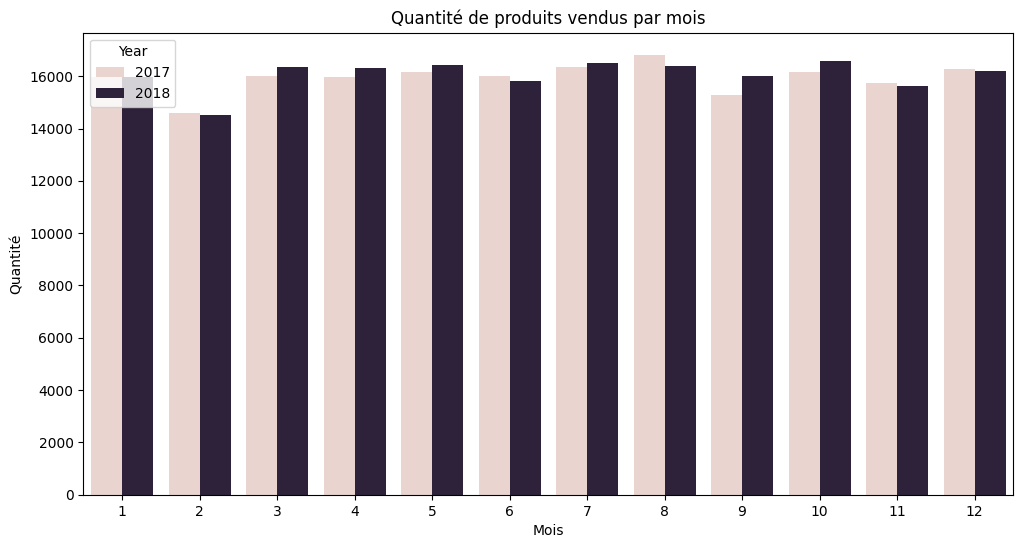

In [ ]:
# Quantité de produits vendus par mois
quantity_by_month = csvdf.groupBy("Month", "Year").sum("Order Item Quantity").orderBy("Year", "Month")
quantity_by_month_pd = quantity_by_month.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=quantity_by_month_pd, x='Month', y='sum(Order Item Quantity)', hue='Year')
plt.title('Quantité de produits vendus par mois')
plt.xlabel('Mois')
plt.ylabel('Quantité')
plt.show()

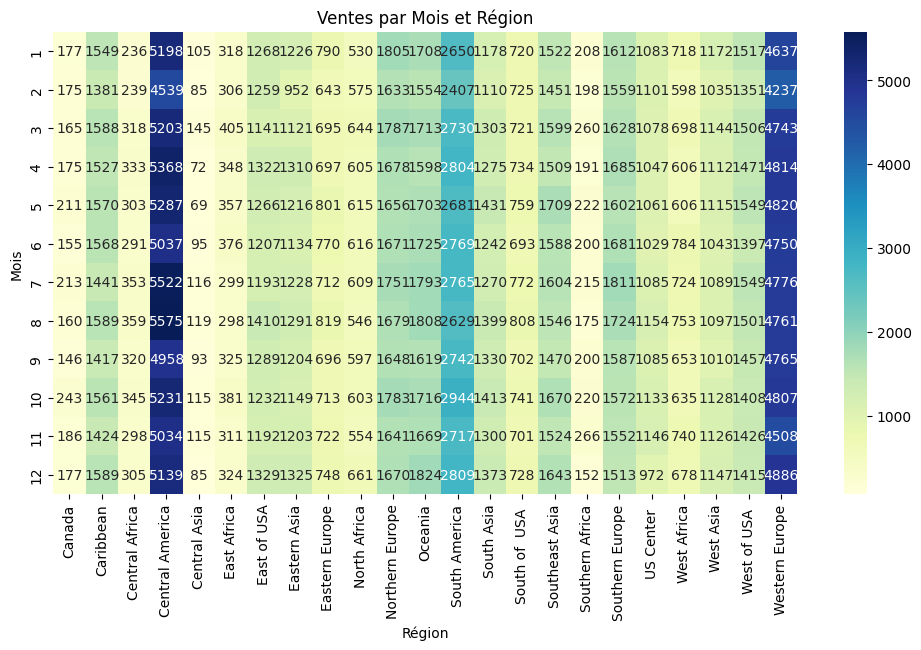

In [ ]:
#Analyse des Ventes par Mois et Région
quantity_by_region = csvdf.groupBy("Order Region", "Month", "Year").sum("Order Item Quantity").orderBy("Year", "Month")
quantity_by_region_pd = quantity_by_region.toPandas()

pivot_table = quantity_by_region_pd.pivot_table(values='sum(Order Item Quantity)', index='Month', columns='Order Region', aggfunc='sum')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Ventes par Mois et Région')
plt.xlabel('Région')
plt.ylabel('Mois')
plt.show()


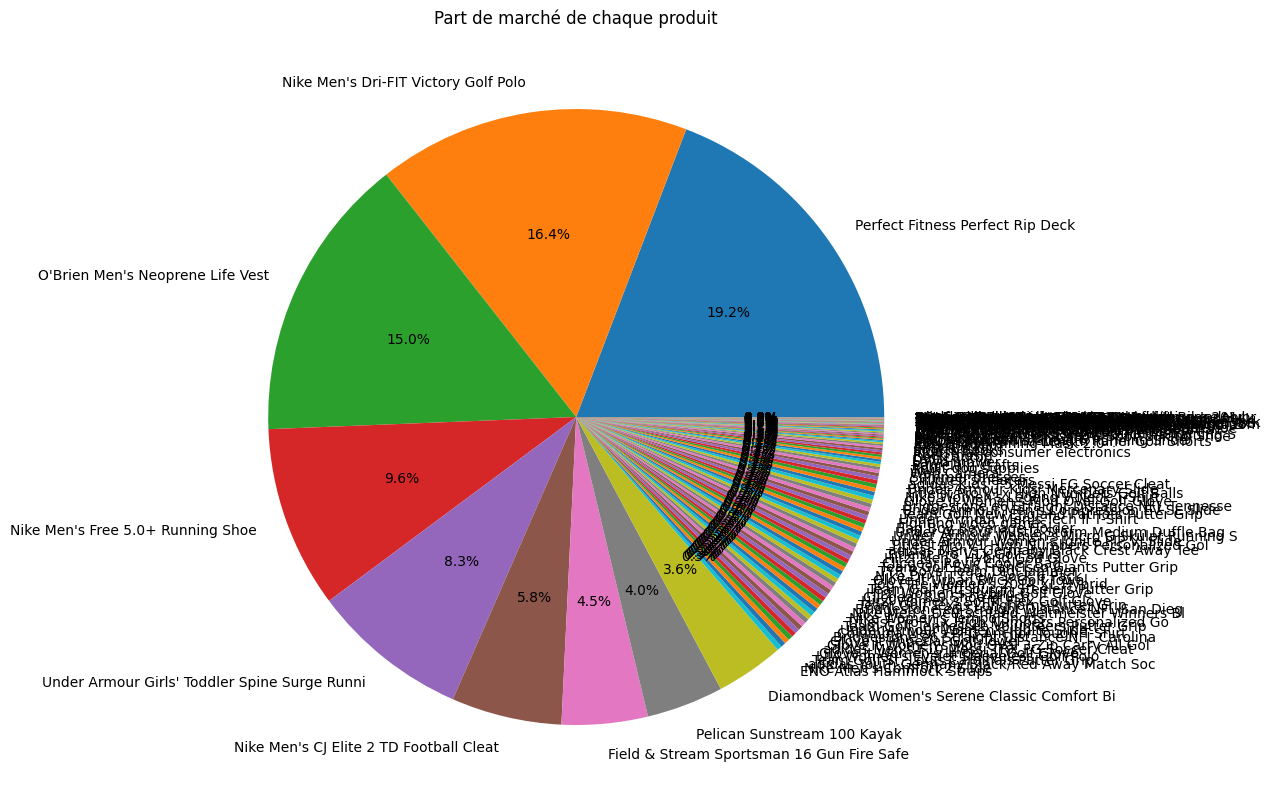

In [ ]:
#Performance des Produits
product_sales = csvdf.groupBy("Product Name").sum("Order Item Quantity").orderBy("sum(Order Item Quantity)", ascending=False)
product_sales_pd = product_sales.toPandas()

plt.figure(figsize=(10, 10))
plt.pie(product_sales_pd['sum(Order Item Quantity)'], labels=product_sales_pd['Product Name'], autopct='%1.1f%%')
plt.title('Part de marché de chaque produit')
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


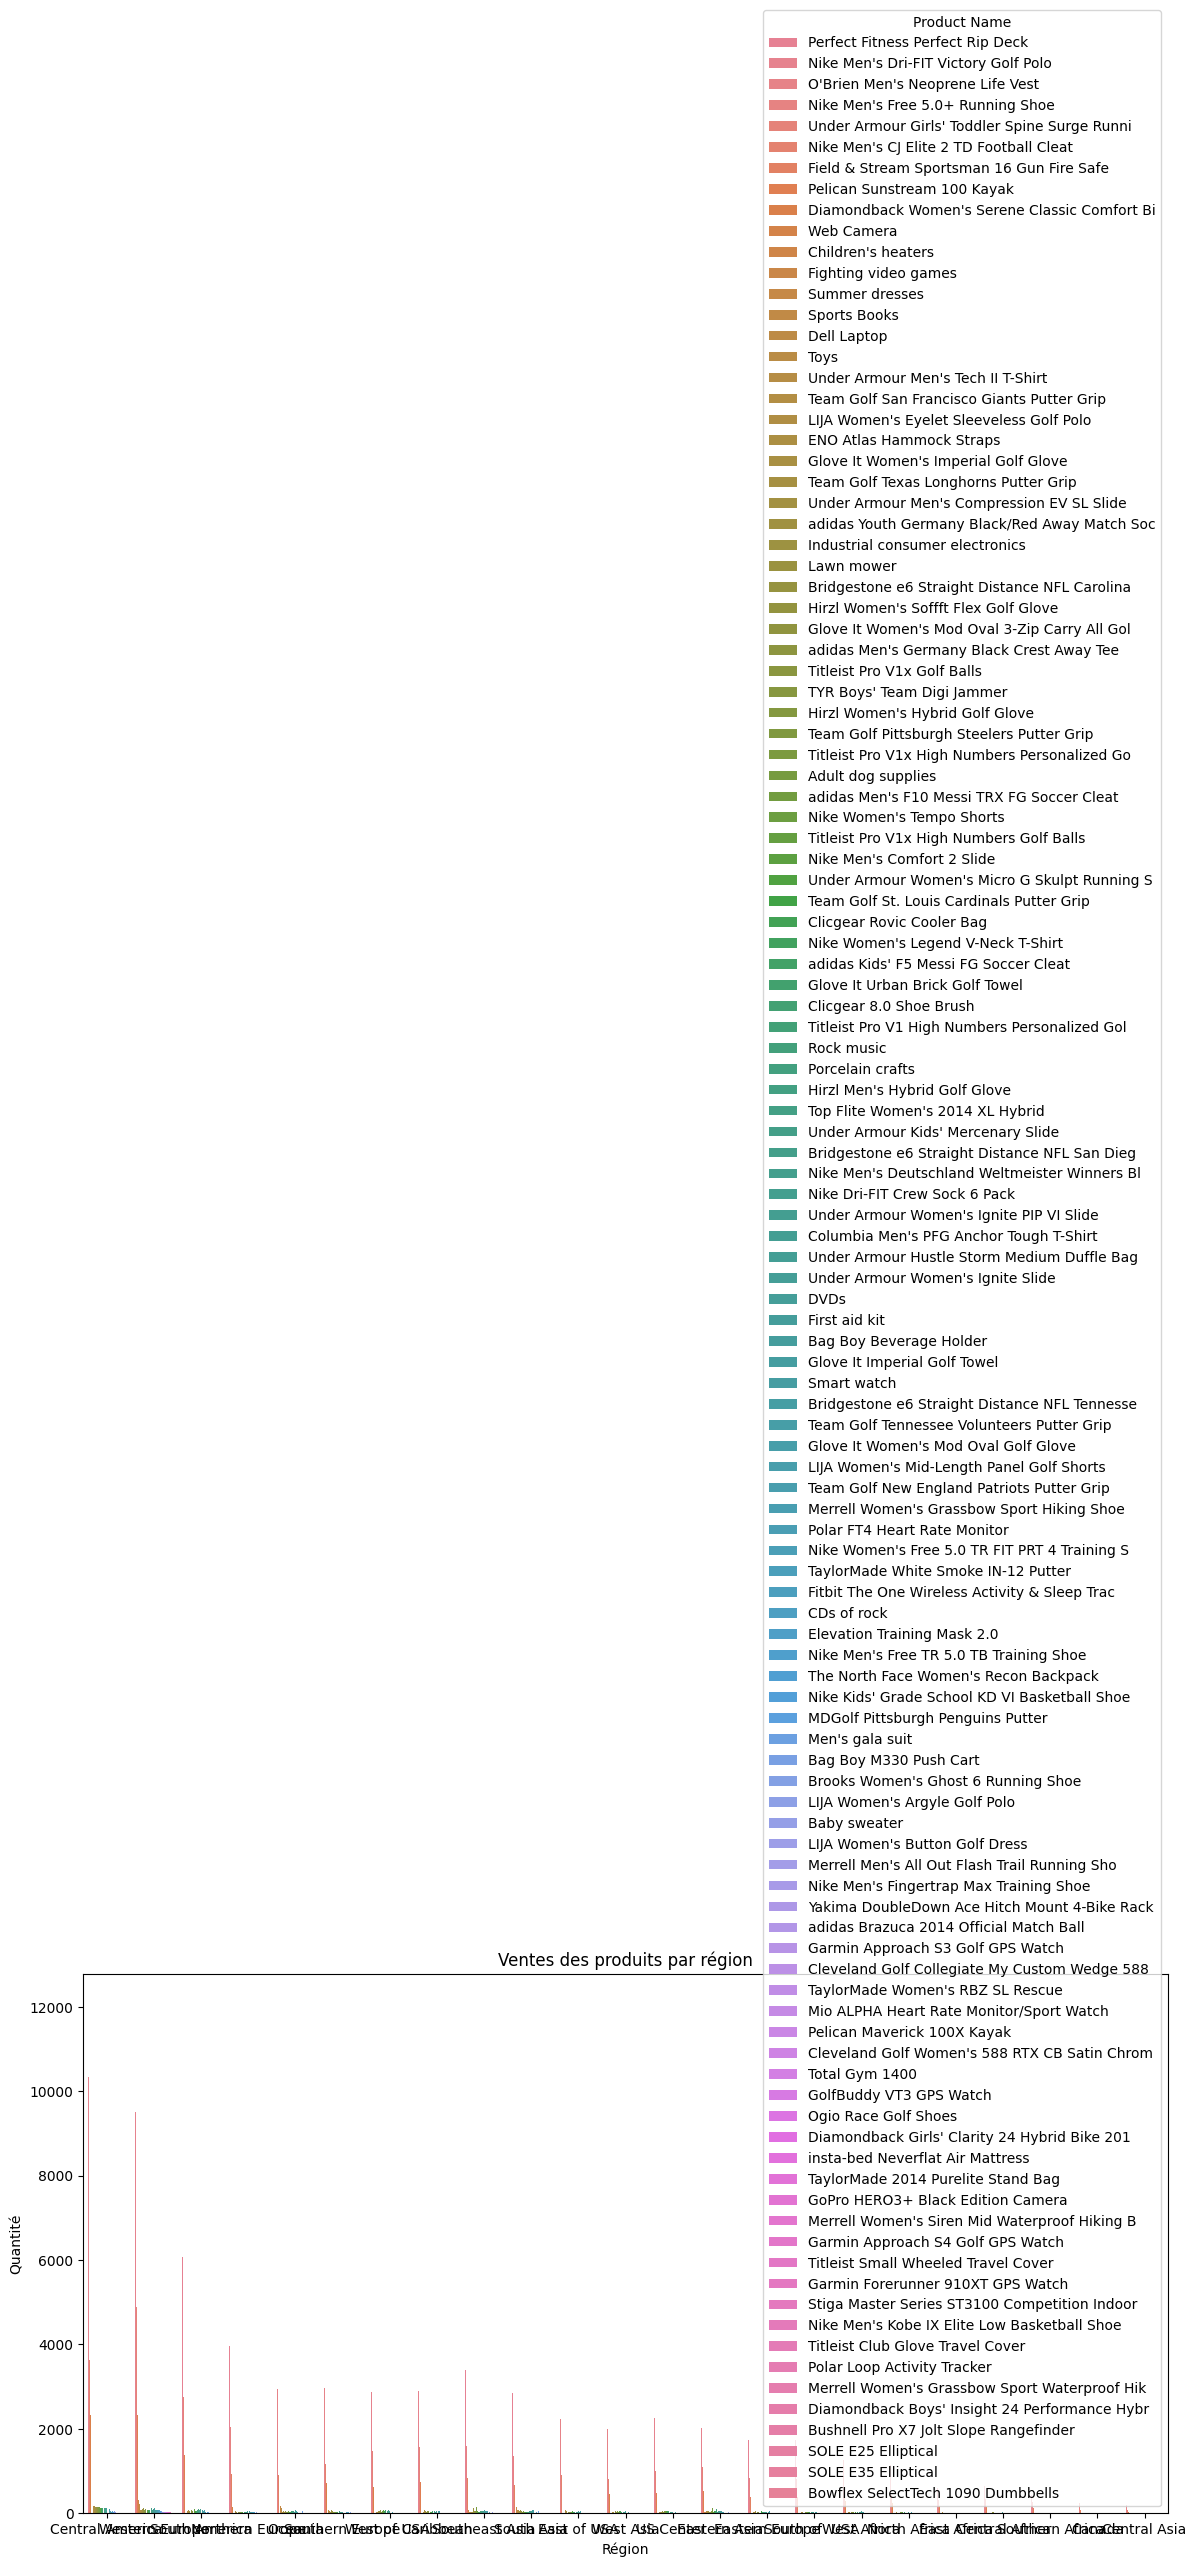

In [ ]:
#Performance des Produits
product_sales_region = csvdf.groupBy("Product Name", "Order Region").sum("Order Item Quantity").orderBy("sum(Order Item Quantity)", ascending=False)
product_sales_region_pd = product_sales_region.toPandas()

plt.figure(figsize=(14, 7))
sns.barplot(data=product_sales_region_pd, x='Order Region', y='sum(Order Item Quantity)', hue='Product Name')
plt.title('Ventes des produits par région')
plt.xlabel('Région')
plt.ylabel('Quantité')
plt.show()

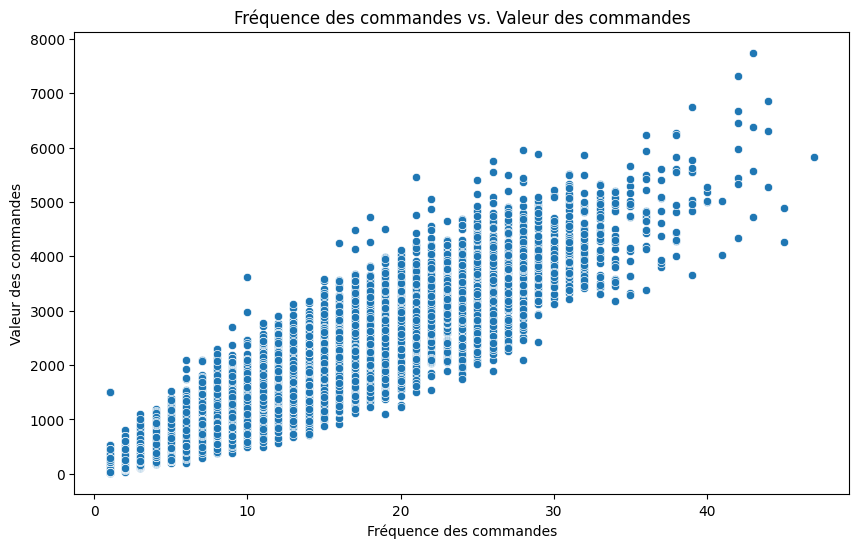

In [ ]:
# Analyse des Clients
customer_order_value = csvdf.groupBy("Customer Id").agg({"Order Item Product Price": "sum", "Order Id": "count"})
customer_order_value_pd = customer_order_value.toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_order_value_pd, x='count(Order Id)', y='sum(Order Item Product Price)')
plt.title('Fréquence des commandes vs. Valeur des commandes')
plt.xlabel('Fréquence des commandes')
plt.ylabel('Valeur des commandes')
plt.show()

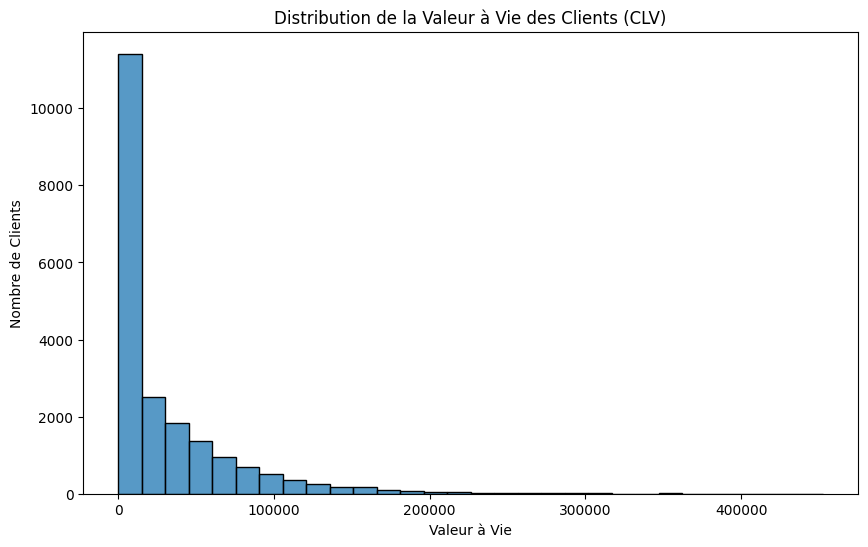

In [ ]:
# Analyse des Clients
clv = csvdf.groupBy("Customer Id").agg({"Sales": "sum", "Order Id": "count"})
clv_pd = clv.toPandas()
clv_pd['CLV'] = clv_pd['sum(Sales)'] * clv_pd['count(Order Id)']

plt.figure(figsize=(10, 6))
sns.histplot(clv_pd['CLV'], bins=30)
plt.title('Distribution de la Valeur à Vie des Clients (CLV)')
plt.xlabel('Valeur à Vie')
plt.ylabel('Nombre de Clients')
plt.show()

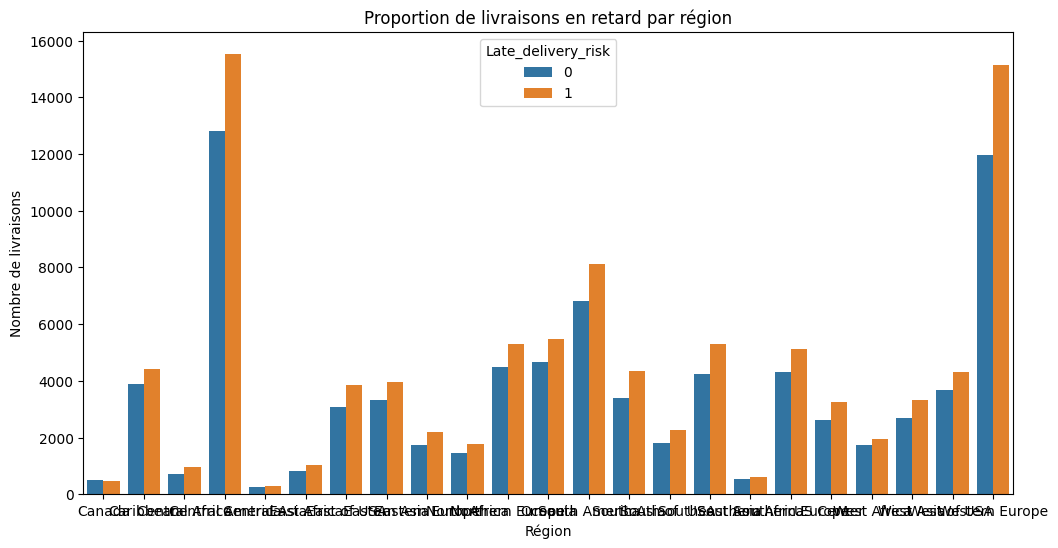

In [ ]:
#Analyse des Retards de Livraison
late_delivery = csvdf.groupBy("Order Region", "Late_delivery_risk").count().orderBy("Order Region")
late_delivery_pd = late_delivery.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=late_delivery_pd, x='Order Region', y='count', hue='Late_delivery_risk')
plt.title('Proportion de livraisons en retard par région')
plt.xlabel('Région')
plt.ylabel('Nombre de livraisons')
plt.show()

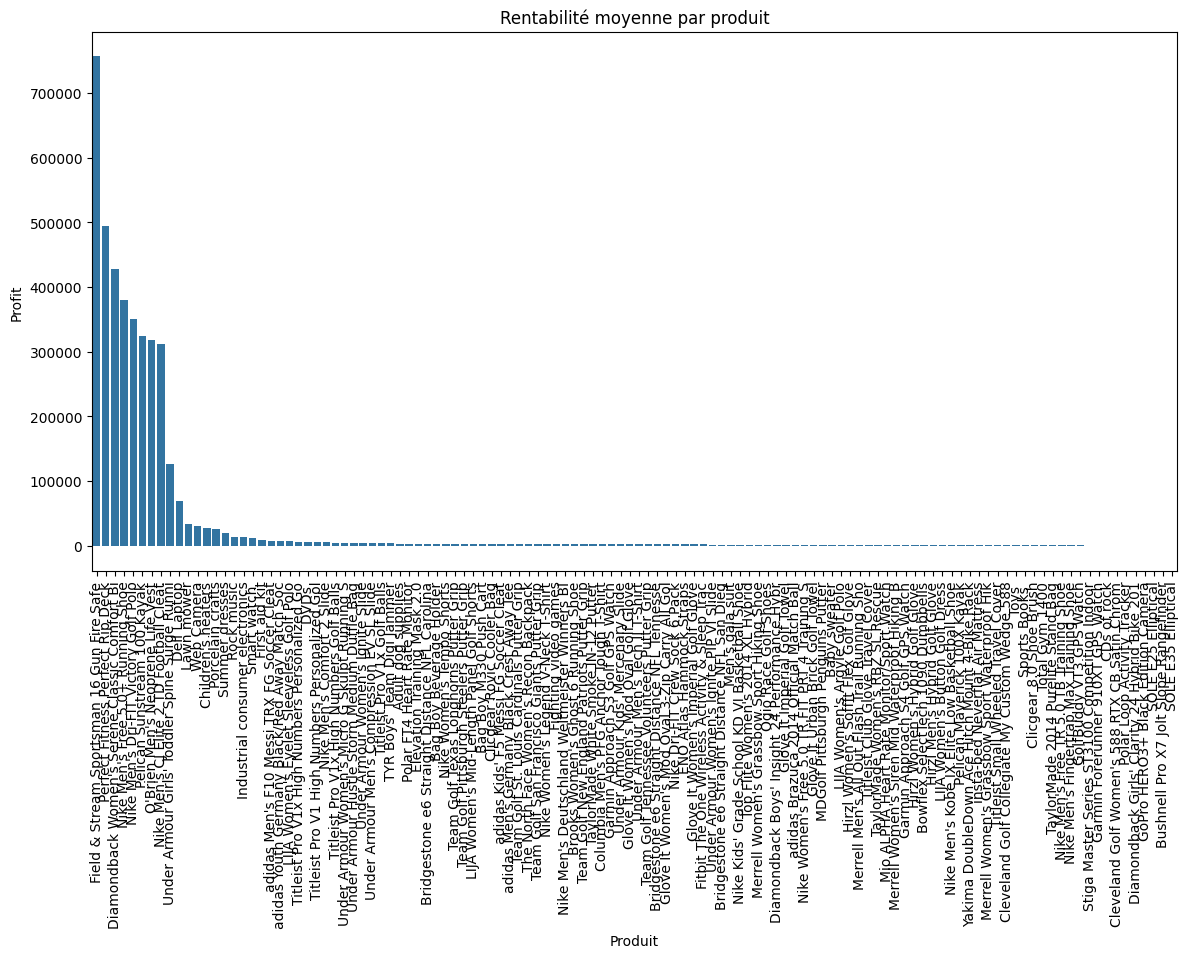

In [ ]:
#Analyse de la Rentabilité des Commandes
profit_by_product = csvdf.groupBy("Product Name").sum("Order Profit Per Order").orderBy("sum(Order Profit Per Order)", ascending=False)
profit_by_product_pd = profit_by_product.toPandas()

plt.figure(figsize=(14, 7))
sns.barplot(data=profit_by_product_pd, x='Product Name', y='sum(Order Profit Per Order)')
plt.title('Rentabilité moyenne par produit')
plt.xlabel('Produit')
plt.ylabel('Profit')
plt.xticks(rotation=90)
plt.show()

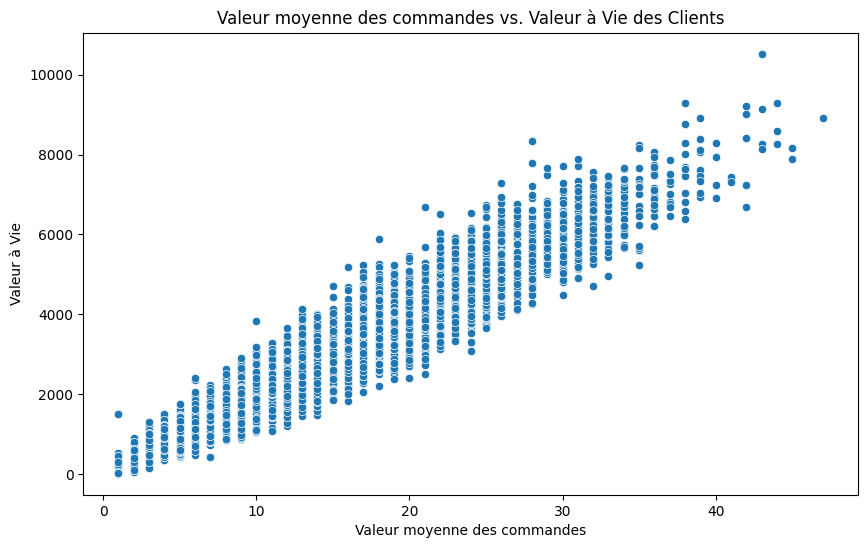

In [ ]:
#Analyse de la Valeur à Vie des Clients (CLV)
clv_df = csvdf.groupBy("Customer Id").agg({"Sales": "sum", "Order Id": "count"})
clv_df = clv_df.withColumn("CLV", clv_df["sum(Sales)"] * clv_df["count(Order Id)"])
clv_pd = clv_df.toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=clv_pd, x='count(Order Id)', y='sum(Sales)')
plt.title('Valeur moyenne des commandes vs. Valeur à Vie des Clients')
plt.xlabel('Valeur moyenne des commandes')
plt.ylabel('Valeur à Vie')
plt.show()

In [ ]:
quantity_by_month1 = csvdf.groupBy("Month","Year","Product Name", "Order Region").sum("Order Item Quantity").orderBy("Month","Year")

In [ ]:
quantity_by_month1.show()

+-----+----+--------------------+---------------+------------------------+
|Month|Year|        Product Name|   Order Region|sum(Order Item Quantity)|
+-----+----+--------------------+---------------+------------------------+
|    1|2017|Under Armour Men'...|     South Asia|                       8|
|    1|2017|Bridgestone e6 St...| Western Europe|                      10|
|    1|2017|Nike Men's Dri-FI...| Eastern Europe|                      58|
|    1|2017|Diamondback Women...|     South Asia|                      20|
|    1|2017|Hirzl Women's Hyb...| Eastern Europe|                       5|
|    1|2017|Field & Stream Sp...|Northern Europe|                      44|
|    1|2017|Under Armour Wome...|Southern Europe|                       3|
|    1|2017|Diamondback Women...|Southern Europe|                      24|
|    1|2017|Under Armour Men'...|Southern Europe|                       4|
|    1|2017|Field & Stream Sp...|      Caribbean|                      40|
|    1|2017|       Sports

In [ ]:
output_dir = "/content/drive/MyDrive/quantity/"
quantity_by_month1.write.format("csv").option("header", "true").mode("overwrite").save(output_dir + "quantity_by_month1.csv")

In [17]:
csvdf.show()

+-----------+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+--------------+----------------+--------------+--------------+----------------+--------------+--------------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+---------------+-------------------+------------+-------------+--------------------------+--------------+-----+----+------------+-------------------+---------------+---------------+-----------------+-------------+------------------+--------+---+
|Customer Id|    Type|Days for shipping (real)|Days for shipment (s

In [18]:
# Afficher les types de données de chaque colonne
for col_name, col_type in csvdf.dtypes:
    print(f"Colonne '{col_name}' : {col_type}")

Colonne 'Customer Id' : int
Colonne 'Type' : string
Colonne 'Days for shipping (real)' : int
Colonne 'Days for shipment (scheduled)' : int
Colonne 'Benefit per order' : double
Colonne 'Sales per customer' : double
Colonne 'Delivery Status' : string
Colonne 'Late_delivery_risk' : int
Colonne 'Category Id' : int
Colonne 'Category Name' : string
Colonne 'Customer City' : string
Colonne 'Customer Country' : string
Colonne 'Customer Fname' : string
Colonne 'Customer Lname' : string
Colonne 'Customer Segment' : string
Colonne 'Customer State' : string
Colonne 'Customer Street' : string
Colonne 'Department Id' : int
Colonne 'Department Name' : string
Colonne 'Latitude' : double
Colonne 'Longitude' : double
Colonne 'Market' : string
Colonne 'Order City' : string
Colonne 'Order Country' : string
Colonne 'Order Customer Id' : int
Colonne 'Order Date (DateOrders)' : timestamp
Colonne 'Order Id' : int
Colonne 'Order Item Cardprod Id' : int
Colonne 'Order Item Discount' : double
Colonne 'Order Item

In [19]:
# Vérifier les valeurs nulles dans chaque colonne du DataFrame csvdf
for col in csvdf.columns:
    print(f"Nombre de valeurs nulles dans la colonne '{col}': {csvdf.filter(csvdf[col].isNull()).count()}")

Nombre de valeurs nulles dans la colonne 'Customer Id': 0
Nombre de valeurs nulles dans la colonne 'Type': 0
Nombre de valeurs nulles dans la colonne 'Days for shipping (real)': 0
Nombre de valeurs nulles dans la colonne 'Days for shipment (scheduled)': 0
Nombre de valeurs nulles dans la colonne 'Benefit per order': 0
Nombre de valeurs nulles dans la colonne 'Sales per customer': 0
Nombre de valeurs nulles dans la colonne 'Delivery Status': 0
Nombre de valeurs nulles dans la colonne 'Late_delivery_risk': 0
Nombre de valeurs nulles dans la colonne 'Category Id': 0
Nombre de valeurs nulles dans la colonne 'Category Name': 0
Nombre de valeurs nulles dans la colonne 'Customer City': 0
Nombre de valeurs nulles dans la colonne 'Customer Country': 0
Nombre de valeurs nulles dans la colonne 'Customer Fname': 0
Nombre de valeurs nulles dans la colonne 'Customer Lname': 0
Nombre de valeurs nulles dans la colonne 'Customer Segment': 0
Nombre de valeurs nulles dans la colonne 'Customer State': 0
N

In [20]:
csvdf_pd = csvdf.toPandas()
csvdf_pd.to_csv("/content/drive/MyDrive/Cleaned_data.csv", index=False)